# Introduction to Neural Networks with Sci-kit Learn and PyTorch

## Goals of this notebook:

* Introduce fundamental techniques of working with neural networks (NNs) in python
* Get familiarity with working on image data
* Introduce the fundamentals of convolutional neural networks (CNNs)
* Code a typical pipeline for training and evaluating NNs and CNNs on image classification tasks in pytorch

### Prerequisite Knowledge

* Basic data analysis skills
* Basic understanding of data mining methodology (i.e., train-test splitting, cross-validation, etc.)
* Basic exposure with implementing machine learning (ML) models in sklearn

## 1. Load essential libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Loan dataset

We will start by working on a rather generic tabular loan dataset. Begin by loading the data into a pandas dataframe and printing out some summary info.

* As can be seen, the dataset consists of 14 columns (features) along with 9,578 rows (data points / entries)
* Notice, the last feature 'not.fully.paid' is a binary variable which is our target for this dataset. Thus, this is what we are trying to predict

In [2]:
loan_data = pd.read_csv(r'loan_data.csv')
loan_data.info()
print(loan_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB
(9578, 14)


## Drop the 'purpose' column
The only reason we do this is because it is non-numerical and, as a result, requires some engineering in order to be used as a valid feature that we can feed to a model. As this is not a tutorial on feature engineering, we will simply ignore it for now.

In [3]:
loan_data.drop(columns = ['purpose'], axis=0, inplace = True)

## Visualize the data
* Essential first step when working with any new dataset

Text(0.5, 0, 'fico')

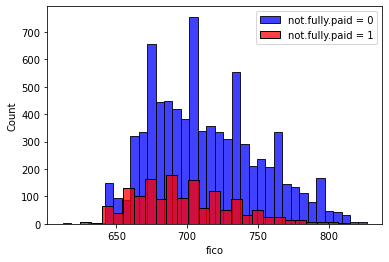

In [4]:
#Distributions of the target variable over fico scores
sns.histplot(loan_data[loan_data['not.fully.paid']==0]['fico'], color = 'blue', label = 'not.fully.paid = 0')
sns.histplot(loan_data[loan_data['not.fully.paid']==1]['fico'], color = 'red', label = 'not.fully.paid = 1')
plt.legend()
plt.xlabel('fico')

Text(0.5, 0, 'revol.util')

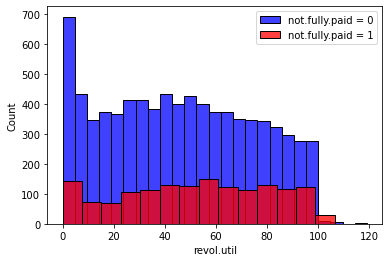

In [5]:
#Distributions of the target variable over revol.util
sns.histplot(loan_data[loan_data['not.fully.paid']==0]['revol.util'], color = 'blue', label = 'not.fully.paid = 0')
sns.histplot(loan_data[loan_data['not.fully.paid']==1]['revol.util'], color = 'red', label = 'not.fully.paid = 1')
plt.legend()
plt.xlabel('revol.util')

Text(0.5, 0, 'int.rate')

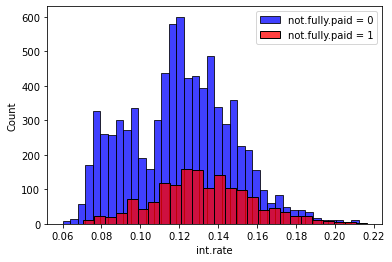

In [6]:
#Distributions of the target variable over int.rate
sns.histplot(loan_data[loan_data['not.fully.paid']==0]['int.rate'], color = 'blue', label = 'not.fully.paid = 0')
sns.histplot(loan_data[loan_data['not.fully.paid']==1]['int.rate'], color = 'red', label = 'not.fully.paid = 1')
plt.legend()
plt.xlabel('int.rate')

## Let's look at the target variable a little closer

As a rule of thumb, we should always look at the ratio of the classes in our prediction target if we are dealing with a classification problem.

* This is to understand if we have a class-imbalance problem, which we do in this case (about 84% of the target variable entries are 0s...)
* This means that as a baseline, if we predicted all 0s for our target variable, we would expect to have about 84% accuracy. Thus, we will be evaluating any model we create against this benchmark value.

Ratio of 0/1 'not fully paid' scores: 8045/1533
Percentage of 0 scores: 0.8399457089162664


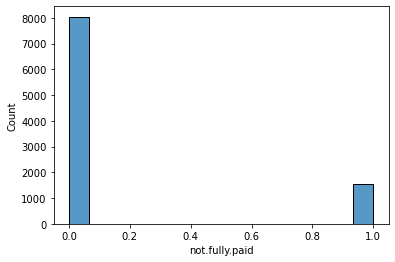

In [7]:
#Histogram of the target variable
sns.histplot(loan_data['not.fully.paid'])
num_1_scores = np.sum(loan_data[loan_data['not.fully.paid']==1]['not.fully.paid'])
num_0_scores = loan_data.shape[0] - num_1_scores
print("Ratio of 0/1 'not fully paid' scores: "+str(num_0_scores)+"/"+str(num_1_scores))
print("Percentage of 0 scores: "+str(num_0_scores / (num_0_scores+num_1_scores)))

## 2. Create a baseline ML model

* Here, we simply want to set up a simple sklearn model (any ML model will work) so that we can have another model to compare the NN to when we introduce it

### Perform a train/test split of the data

Again, since this isn't a tutorial on the full datamining process, we will refrain from extensive cross-validation. For our purposes, we simply need a train-test split of the data.

* We use a simple 30/70 split for the testing and training sets
* As can be seen, we are left with a training set with a size of 6,704 rows and a validation (or testing) set with a size of 2,874 rows

In [8]:
from sklearn.model_selection import train_test_split
X = loan_data.drop('not.fully.paid', axis=1, inplace=False)
y = loan_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape)
print(X_test.shape)

(6704, 12)
(2874, 12)


## Train ML model and generate predictions

* We will train a simple random forest model as our comparison model

In [9]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=42).fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

### Evaluate the model

* As can be seen, the model completely overfit on the training set (100% accuracy) and only had an 83.6% accuracy on the validation set
* However, recall that our baseline accuracy was 84%. So it seems obvious that this first model is nothing to write home about 
* We could definitely do something about this; however, we don't really care for the purposes of this notebook, so we will leave it as is

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
print("Accuracy on Training set: ", rf_model.score(X_train, y_train))
print("Accuracy on Test set: ", accuracy_score(rf_preds, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))

Accuracy on Training set:  1.0
Accuracy on Test set:  0.8364648573416841
Confusion Matrix:
 [[2397   11]
 [ 459    7]]


## 3. Train a Neural Net with Sklearn

We now turn our attenstion to the NN model that is available in sklearn to get some familiarity.

Perhaps the simplest way we can create and train a NN straight out of the box is with scikit-learn's MLP (Multi-Layer Perceptron). This is a fully-connected NN where we can define the number of hidden-layers, the learning rate, the activation function, the regularization, the algorithm used as the optimizer (SGD, ADAM, or LBFGS), etc.

* Overall, this is a very simple "pain-free" way to obtain a NN without any struggle, as all of the work is done behind the scenes.

### Train a total of three simple NNs (covering all of the available optimizers)

Notice that the default solver used is set to ADAM.

In [15]:
from sklearn.neural_network import MLPClassifier
#NN trained with ADAM
mlp_basic = MLPClassifier(random_state=42, solver='adam', max_iter=5000).fit(X_train, y_train) #Default solver is adam
mlp_basic_preds = mlp_basic.predict(X_test)
print("Accuracy on Training set: ", mlp_basic.score(X_train, y_train))
print("Accuracy on Test set: ", accuracy_score(mlp_basic_preds, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, mlp_basic_preds))

Accuracy on Training set:  0.7943019093078759
Accuracy on Test set:  0.7967988865692415
Confusion Matrix:
 [[2243  165]
 [ 419   47]]


NN trained via LBFGS (LBFGS is an optimizer in the family of quasi-Newton methods).

In [16]:
#NN trained with LBFGS
mlp_lbfgs = MLPClassifier(random_state=42, solver='lbfgs', max_iter=5000).fit(X_train, y_train)
mlp_lbfgs_preds = mlp_lbfgs.predict(X_test)
print("Accuracy on Training set: ", mlp_lbfgs.score(X_train, y_train))
print("Accuracy on Test set: ", accuracy_score(mlp_lbfgs_preds, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, mlp_lbfgs_preds))

Accuracy on Training set:  0.8408412887828163
Accuracy on Test set:  0.83785664578984
Confusion Matrix:
 [[2408    0]
 [ 466    0]]


C:\Users\thegr\anaconda3\envs\py36\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


NN trained via classical SGD.

In [17]:
#NN trained with SGD
mlp_sgd = MLPClassifier(random_state=42, solver='sgd', max_iter=5000).fit(X_train, y_train)
mlp_sgd_preds = mlp_sgd.predict(X_test)
print("Accuracy on Training set: ", mlp_sgd.score(X_train, y_train))
print("Accuracy on Test set: ", accuracy_score(mlp_sgd_preds, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, mlp_sgd_preds))

Accuracy on Training set:  0.841736276849642
Accuracy on Test set:  0.837160751565762
Confusion Matrix:
 [[2404    4]
 [ 464    2]]


* Of the three methods, its seems that ADAM performed the worst (accuracy of 79.6%) while LBFGS and SGD performed about the same (accuracy of 83.7%) and matched the random forest

## Visualize the weights of the NN that were learned

* This is one way that we can visualize what's going on withing the network

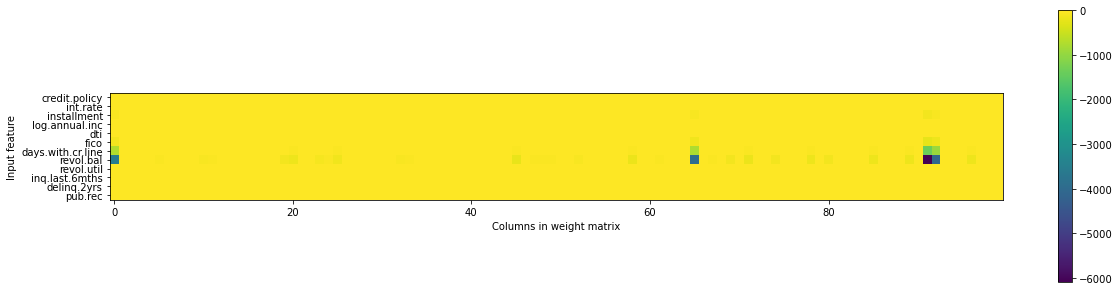

In [18]:
#Visualize the weights of our model that were learned by using a color bar
plt.figure(figsize=(20, 5))
plt.imshow(mlp_sgd.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(12), X_train.columns)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()

## Simple example of a NN with many hyperparameters

* This will get our ADAM optimized NN up to par with the others
* However, notice that our model purely predicted only the 0 class, yielding the expected 83-84% accuracy...
* Again, we don't cara bout this because we have not performed any actual data mining which would theoretically pull out more useful features for our models to make predictions from

In [19]:
#NN example with lots of hyperparameters
mlp_hyp = MLPClassifier(random_state=42, solver='adam', max_iter=5000, learning_rate_init=0.1, alpha=1, hidden_layer_sizes = (100, 100), activation='relu').fit(X_train, y_train)
mlp_hyp_preds = mlp_hyp.predict(X_test)
print("Accuracy on Training set: ", mlp_hyp.score(X_train, y_train))
print("Accuracy on Test set: ", accuracy_score(mlp_hyp_preds, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, mlp_hyp_preds))

Accuracy on Training set:  0.8408412887828163
Accuracy on Test set:  0.83785664578984
Confusion Matrix:
 [[2408    0]
 [ 466    0]]


Let's look at the weights between the two hidden layers in this NN.

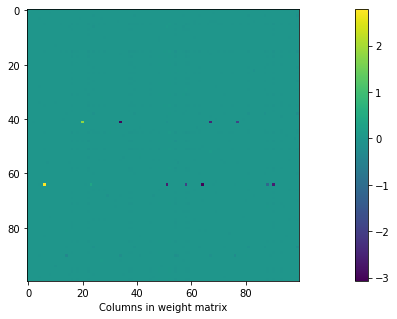

In [20]:
#Visualize the weights of our model that were learned by using a color bar
plt.figure(figsize=(20, 5))
plt.imshow(mlp_hyp.coefs_[1], interpolation='none', cmap='viridis')
plt.xlabel("Columns in weight matrix")
plt.colorbar()

##  4. Fully-Connected Feed-Forward Neural Nets with PyTorch
### Use torchvision to import the MNIST image dataset

MNIST is a classic dataset that is used in deep learning and is comprised of 70,000 black-and-white images of hand-written digits.

Torchvision has a library of classical datasets (the library itself is named datasets) that are popularly used to train deep neural nets on, such as MNIST, CIFAR-10, ImageNet, etc.

These datasets are used extensively in deep learning research papers as they provide a proper real-world challenge when claiming that a new algorithm has certain amiable performance properties. If any new algorithm or methodology is proposed in the field of ML or DL, these datasets will typically be used to verify the numerical results.

However, to start, it is useful to define the following random seed setting function. This is useful when working with pytorch in particular, because there are a lot of different sources of randomness that can occur, and we want them all to be eliminated in order to be able to reproduce results.

In [21]:
import random
import torch
import os

#Function to set the seed
def Set_Seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)

#Set the seed
Set_Seed(42)

### Set the device that we will train the model on (GPU or CPU)

PyTorch uses a data structure known as a tensor. In mathematics, there are vectors (1-dimensional arrays) and matrices (2-dimensional arrays). Similarly, there are also tensors, which typically refer to an n-dimensional array. Thus, a vector is technically a 1-D tensor, a matrix is a 2-D tensor, and so on.

However, when it comes to PyTorch, the tensor data structure is essentially the same as the Numpy array, as they have (basically) the same functionality. The only real difference, is that tensors can run on the CPU or the GPU, which makes them unique and definitely optimal for training deep NNs on large datasets, since the GPU will give you a very large speed-up.

In [22]:
#Set the device for pytorch to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu" #We will use the cpu since not all computers have a GPU
print(device)

cpu


### Load the MNIST training and testing datasets

Torchvision has already segregated the MNIST dataset into a training dataset that consists of 60,000 images and a testing dataset that consists of 10,000 images.

In [23]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
#Load the MNIST dataset
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

C:\Users\thegr\anaconda3\envs\py36\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Define training and testing loaders using PyTorch's DataLoader

PyTorch's DataLoader is a very useful structure that we can use to store our datasets. This will become more clear later, but in short, the DataLoader lets us "pre-batch" both the training and testing datasets into whhatever batch sizes we want. This will be useful when we are training our NNs with SGD.

For simplicity we will use batch sizes that are 1% the size of the respective datasets. Thus, our training loader will consist of 100 batches of 600 images, whereas our testing loader will consist of 100 batches of 100 images.

In [24]:
train_loader = DataLoader(mnist_train, batch_size = int(0.01*60000), shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = int(0.01*10000), shuffle=True)

### Let's inspect the MNIST data
* As can be seen, there are 10 classes, one for each of the digits

In [25]:
print(mnist_train.classes) #The classes

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


Now, let's look at the dimensions of a single image; it is a 3-dimensional tensor, it has 1 channel (black/white) and is a 28x28 image

In [26]:
print(mnist_train[0][0].numpy().shape)
print("Label of this image: ", mnist_train[0][1])

(1, 28, 28)
Label of this image:  5


### Visualize an MNIST image

Label:  5 - five (5)


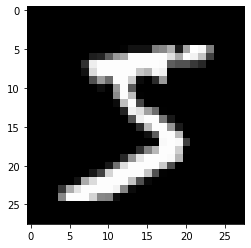

In [27]:
#Function to plot the image via matplotlib
def show_example(img, label):
    print('Label: ', mnist_train.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0),cmap='gray')

show_example(*mnist_train[0]) #or use show_example(mnist_train[0][0], mnist_train[0][1])

### Visualize a batch of images

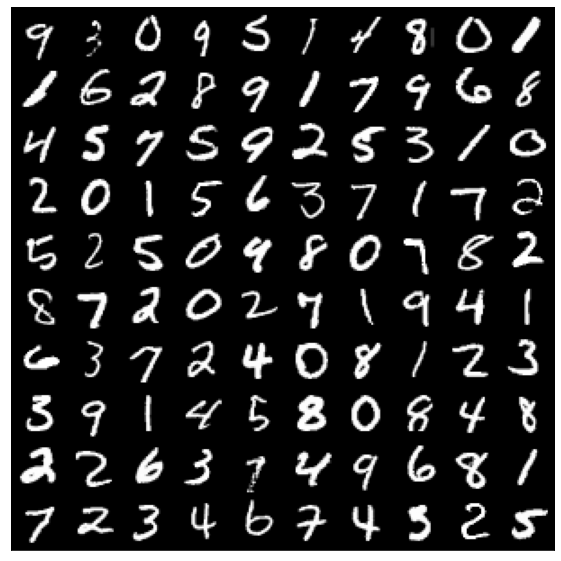

In [28]:
#View the images in a batch
from torchvision.utils import make_grid
def show_batch(dl, grid_param):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, grid_param).permute(1,2,0),cmap='gray')
        break
#Plot the grid of a batch in the testing loader
show_batch(test_loader, 10)

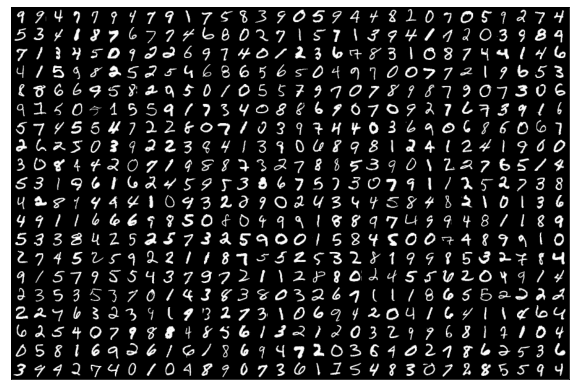

In [29]:
#Plot the grid of a batch in the training loader
show_batch(train_loader, 30)

## 5. Define a Fully-Connected Feed-Forward NN for MNIST

We are now ready to use PyTorch to define and implement neural nets. The nn.Sequential function essentially acts as the "container" for our NN, of which the input passes through all of its "interior" components such as the layers of the network that we define. Since this is a feed-forward NN, we can simply define each layer of the NN followed by whichever activation function we want to use (relu, tanh, etc.). In PyTorch, the Linear function is not refering to linear regression, but instead refers to a fully-connected layer in the network that has 'in_features' number of input nodes and 'out_features' number of output nodes.

Thus, since we want to define a simple fully-connected NN, we want to start by flattening out the 28x28 input image into a 1-D vector of length 28*28 = 784. Then we can define our first Linear layer that turns the 784 inputs into a hidden layer of 1,000 nodes (this was an arbitrary choice for the size). Then, we can add in nonlinearity to our network by passing the output through the ReLU function. Finally, we can define one more Linear layer that takes the 1,000 outputs of the hidden layer and connects them to 10 output nodes (10 because we have a total of 10 classes that we are trying to predict).

In [30]:
import torch.nn as nn

def Generate_Model():
    fully_conn_nn = nn.Sequential(nn.Flatten(),
                                  nn.Linear(in_features=1*28*28, out_features=1000),
                                  nn.ReLU(),
                                  nn.Linear(in_features=1000, out_features=10)).to(device)
    return fully_conn_nn

model = Generate_Model()

## A simple pass through our untrained network
What do you notice about the output of our model?

In [31]:
#Let's look at the output of the model on a single training batch
for images, labels in train_loader:
    print('images.shape:', images.shape) #Print the size of the batch (600 images that are 28x28)
    out = model(images.to(device))
    print('out.shape:', out.shape) #Print the size of the output of the model (600 10-D vectors)
    print('out[0]:', out[0]) #Print a single output from the batch
    break

images.shape: torch.Size([600, 1, 28, 28])
out.shape: torch.Size([600, 10])
out[0]: tensor([-0.1055,  0.0785, -0.0848,  0.0383,  0.0301, -0.0970, -0.1295,  0.0026,
         0.0254, -0.1213], grad_fn=<SelectBackward>)


* Notice that the output of the NN is a batch of 10-dimensional vectors, where each vector corresponds to a single image prediction
* However, the vectors contain the values that the NN assigned with each class
* Thus, we want to convert these output values into probabilities
* This can be done by taking a softmax. Now, we can tell which class our model will predict.

In [33]:
import torch.nn.functional as F
softmax = F.softmax(out[0], dim=0)
print(softmax)
print('Sum: ', np.sum(softmax.detach().numpy())) #Make sure that the outputs sum to 1 (verifying that this is a probability)

tensor([0.0931, 0.1119, 0.0950, 0.1074, 0.1066, 0.0939, 0.0909, 0.1037, 0.1061,
        0.0916], grad_fn=<SoftmaxBackward>)
Sum:  1.0


## 6. Write the optimizer to train the NN
This is the function that we will call that will ultimately train our model.

This function consists of looping through the training dataset for some set number of 'epochs' that we choose, sampling training batches that we will pass through the NN in order to generate a prediction; using this prediction we can compute the loss via the loss criteria that we choose; we can then compute the gradients of our NNs parameters by calling .backward on the loss (this computes the gradients by using the backpropigation algorithm and autograd); finally, we can use the optimizer that we defined to take a single step in the direction of descent.

In [34]:
#Train the NN to optimality
def NN_Optimizer(model, func, train_loader, test_loader, epochs, lr, optimizer):
    #Initilize some of the data
    train_loss_list = []
    test_loss_list = []
    #Iterate through the number of epochs
    for epoch in range(epochs):
        print(epoch)
        j = 0
        #For each epoch, iterate through all of the training batches
        for X_train, y_train in train_loader:
            X_train = X_train.to(device); y_train = y_train.to(device)
            #print("iteration: " + str(j))
            #Update the variables with a single step
            model.train() #Puts the model into the "training" mode (makes sure to track the gradients)
            optimizer.zero_grad() #Zeros out the gradients from the previous update
            pred = model(X_train) #Use the model to predict the outputs of the batch
            loss = func(pred, y_train) #Compute the error of the prediction
            loss.backward() #Using the error, backpropigate to compute the gradients
            optimizer.step() #Using the gradients that were computed, update the model with a single step via the optimizer that was chosen
            j += 1
            
            #Compute the loss on the training dataset
            train_loss_list.append(float(func(model(X_train), y_train)))
            #Compute the loss on the testing dataset
            X_test, y_test = next(iter(test_loader))
            X_test = X_test.to(device); y_test = y_test.to(device)
            model.eval() #Puts the model into the "evaluation" mode (doesn't track the gradients)
            test_loss_list.append(float(func(model(X_test), y_test)))
    return [train_loss_list, test_loss_list]

### Train the NN on the MNIST dataset

* We will train our NN for a total of 10 epochs
* We will use SGD as our optimization algorithm

In [35]:
Set_Seed(42) #Set the random seed
model = Generate_Model() #Define a new NN
func = nn.CrossEntropyLoss().to(device) #Define the corss-entropy loss as our function that we are tring to minize
epochs = 10 #Number of epochs we will train our model for
lr = 0.05 #learning rate
optimizer = torch.optim.SGD(model.parameters(), lr) #Use SGD as the optimization algorithm

sol = NN_Optimizer(model, func, train_loader, test_loader, epochs, lr, optimizer) #Train our NN
train_loss = sol[0]
testing_loss = sol[1]

0
1
2
3
4
5
6
7
8
9


### Plot the training loss and testing loss of our NN over the iterations

Text(0, 0.5, 'Cross Entropy Loss')

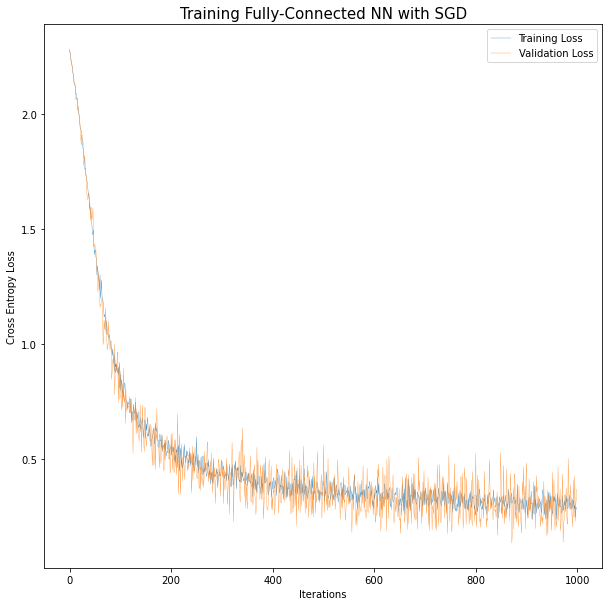

In [36]:
#Plot the losses
iter_list = [i for i in range(len(train_loss))]
plt.figure(figsize=(10, 10))
sns.lineplot(x=iter_list, y=train_loss, linewidth=0.3, label='Training Loss', legend=True).set_title('Training Fully-Connected NN with SGD', size=15)
sns.lineplot(x=iter_list, y=testing_loss, linewidth=0.3, label='Validation Loss')
plt.xlabel("Iterations")
plt.ylabel("Cross Entropy Loss")

## 7. Summary

* We have seen how to work with NNs for general tabular datasets in sklearn and for image-classification tasks in pytorch
* Designing the architectures of NNs is more of an art than a science (although there is research being done to automate the design phase of NNs in an optimal way)
* we have covered the basics of pytorch when dealing with NNs